# Linear Regression Implementation

### 1. Linear Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

plt.style.use('seaborn')
%matplotlib inline

In [2]:
df = pd.read_csv('sales.csv')
df

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9
...,...,...,...,...,...
195,196,38.2,3.7,13.8,7.6
196,197,94.2,4.9,8.1,9.7
197,198,177.0,9.3,6.4,12.8
198,199,283.6,42.0,66.2,25.5


In [3]:
# prepare X (features) and y (target)
feature_cols = ['TV', 'Newspaper', 'Radio']
X = df[feature_cols]
y = df['Sales']

In [4]:
scaler = StandardScaler()

# do train_test_split (train:75, test:25)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# do scaling for training convergence
X_train, X_test = scaler.fit_transform(X_train), scaler.fit_transform(X_test)

In [5]:
# determine whether system supports CUDA or not 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
# convert numpy arrays into pytorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [7]:
cost = []

class LinearRegression(torch.nn.Module):
    
    def __init__(self, num_features):
        super(LinearRegression, self).__init__()       
        self.num_features = num_features
        self.linear = torch.nn.Linear(num_features, 1)
        self.linear.weight.detach().normal_(0, .1)
        self.linear.bias.detach().zero_()
        
    
    def forward(self, x):
        logits = self.linear(x)
        yhat = logits.view(-1)
        return yhat
    

    def train(self, x, y, num_epochs, learning_rate=0.1):
        
        # use gradient descent as the optimizer
        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        
        for e in range(num_epochs):
            
            # compute outputs ###
            yhat = self.forward(x)
            
            # compute the loss
            loss = F.mse_loss(yhat, y, reduction='mean')
            
            # reset gradients from the previous interaction
            optimizer.zero_grad()
            
            # comp. gradients
            loss.backward()          
            
            # update weights and bias
            optimizer.step()

            
            ### Logging ####
            with torch.no_grad():
                yhat = self.forward(x)
                curr_loss = F.mse_loss(yhat, y, reduction='mean')
                print('Epoch: %03d' %(e+1), end='')
                print(' | MSE: %.3f' %curr_loss)
                cost.append(curr_loss) 
            
    def predict(self, x):
        predictions = self.forward(x)
        return predictions

In [8]:
# training
linreg = LinearRegression(num_features=X_train.size(1))
linreg.to(device)
linreg.train(X_train, y_train, num_epochs=70)

Epoch: 001 | MSE: 140.472
Epoch: 002 | MSE: 90.601
Epoch: 003 | MSE: 58.955
Epoch: 004 | MSE: 38.825
Epoch: 005 | MSE: 25.991
Epoch: 006 | MSE: 17.794
Epoch: 007 | MSE: 12.549
Epoch: 008 | MSE: 9.187
Epoch: 009 | MSE: 7.029
Epoch: 010 | MSE: 5.641
Epoch: 011 | MSE: 4.746
Epoch: 012 | MSE: 4.168
Epoch: 013 | MSE: 3.795
Epoch: 014 | MSE: 3.552
Epoch: 015 | MSE: 3.394
Epoch: 016 | MSE: 3.291
Epoch: 017 | MSE: 3.223
Epoch: 018 | MSE: 3.179
Epoch: 019 | MSE: 3.149
Epoch: 020 | MSE: 3.130
Epoch: 021 | MSE: 3.116
Epoch: 022 | MSE: 3.107
Epoch: 023 | MSE: 3.101
Epoch: 024 | MSE: 3.097
Epoch: 025 | MSE: 3.094
Epoch: 026 | MSE: 3.092
Epoch: 027 | MSE: 3.091
Epoch: 028 | MSE: 3.090
Epoch: 029 | MSE: 3.089
Epoch: 030 | MSE: 3.088
Epoch: 031 | MSE: 3.088
Epoch: 032 | MSE: 3.088
Epoch: 033 | MSE: 3.087
Epoch: 034 | MSE: 3.087
Epoch: 035 | MSE: 3.087
Epoch: 036 | MSE: 3.087
Epoch: 037 | MSE: 3.087
Epoch: 038 | MSE: 3.087
Epoch: 039 | MSE: 3.087
Epoch: 040 | MSE: 3.087
Epoch: 041 | MSE: 3.087
Epoch: 0

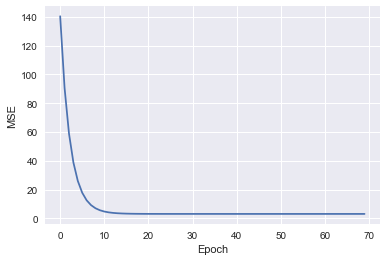

In [9]:
# plot the MSE-loss after each epoch
plt.plot(range(len(cost)), cost)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [10]:
# examine the coefficients and intercept
print(f'Coefficients: {list(zip(feature_cols, linreg.linear.weight.detach()))}')
print(f'Intercept: {linreg.linear.bias.detach()}')
print(f'- MSE: {F.mse_loss(y_test, linreg.predict(X_test).detach()):.3f}')

Coefficients: [('TV', tensor([4.0620, 0.0737, 2.7096]))]
Intercept: tensor([13.8107])
- MSE: 2.872


**Use scikit-learn**

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

print(f'Coefficients: {list(zip(feature_cols, linreg.coef_))}')
print(f'Intercept: {linreg.intercept_:.4f}')
print(f'- MSE: {mean_squared_error(y_test, y_pred):.3f}')

Coefficients: [('TV', 4.0620537), ('Newspaper', 0.073443495), ('Radio', 2.7098477)]
Intercept: 13.8107
- MSE: 2.872


**Analytical solution**
$$(X^T.X)^{-1}.X^T.y$$
- Set: $$a = (X^T.X)^{-1}, b=a.X^T, w=b.y$$
- After finding w, we can compute the bias by: 
$$bias = W.X - y$$

In [12]:
a = torch.inverse(torch.mm(X_train.T, X_train))
b = torch.mm(a, X_train.T)

w = torch.mm(b, y_train.view(-1, 1))
bias = (y_train - torch.mm(X_train, w).view(-1))[0]

print(f'Coefficients: {list(zip(feature_cols, w.view(-1).numpy()))}')
print(f'Intercept: {bias:.3f}')

Coefficients: [('TV', 4.062052), ('Newspaper', 0.07344389), ('Radio', 2.7098463)]
Intercept: 15.089
